<a href="https://colab.research.google.com/github/domjerse/grafico-dashboard/blob/main/modelos_graficos_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GRAFICO DE ATIVIDADES 2024

In [88]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from scipy.stats import norm, skew, kurtosis
import gspread
from google.auth import default

plt.style.use('ggplot')

# Autenticação automática no Colab
creds, _ = default()
gc = gspread.authorize(creds)

# Abrir a planilha pelo ID
sheet_id = "1ES5xPgTlVm9EalLDoWfXDHKCJeA48_4iAzgA9QxD7qs"
sh = gc.open_by_key(sheet_id)

# Abrir a aba específica
worksheet = sh.worksheet("uf_atividades")
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Certificar que colunas numéricas estão no tipo correto
df['mes'] = df['mes'].astype(int)
df['realizado'] = pd.to_numeric(df['realizado'], errors='coerce')
df['previsto'] = pd.to_numeric(df['previsto'], errors='coerce')

# Combo box
ufs = sorted(df['uf'].unique())
uf_dropdown = widgets.Dropdown(
    options=ufs,
    value=ufs[0],
    description='UF:',
)

def plot_uf(uf):
    df_uf = df[df['uf'] == uf].sort_values('mes')
    perc = (df_uf['realizado'] / df_uf['previsto'] * 100).round(1)

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    # === Gráfico 1: Linhas + Barras ===
    ax1.plot(df_uf['mes'], df_uf['realizado'], marker='o', label='Realizado', color='tab:blue')
    ax1.plot(df_uf['mes'], df_uf['previsto'], marker='x', linestyle='--', label='Previsto', color='tab:orange')
    ax1.set_xlabel('Mês')
    ax1.set_ylabel('Valores')
    ax1.set_xticks(range(1,13))
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Realizado x Previsto - {uf}')

    ax1b = ax1.twinx()
    ax1b.bar(df_uf['mes'], perc, alpha=0.3, color='tab:green', label='% Previsto/Realizado')
    ax1b.set_ylabel('% Previsto / Realizado', color='tab:green')
    ax1b.set_ylim(0, 120)

    lines, labels = ax1.get_legend_handles_labels()
    bars, bar_labels = ax1b.get_legend_handles_labels()
    ax1.legend(lines + bars, labels + bar_labels, loc='upper left', fontsize=10)

    # === Gráfico 2: Boxplot ===
    data_box = [df_uf['realizado'], df_uf['previsto']]
    labels_box = ['Realizado', 'Previsto']
    box = ax2.boxplot(data_box, tick_labels=labels_box, patch_artist=True,
                      medianprops=dict(color="red", linewidth=2))
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    stats = [np.percentile(col, [0,25,50,75,100]) for col in data_box]
    for i, stat in enumerate(stats):
        ax2.text(i+1.15, stat[2], f"Mediana={stat[2]:.0f}", va="center", fontsize=10, color="red")
        ax2.text(i+1.15, stat[0], f"Min={stat[0]:.0f}", va="center", fontsize=9)
        ax2.text(i+1.15, stat[1], f"Q1={stat[1]:.0f}", va="center", fontsize=9)
        ax2.text(i+1.15, stat[3], f"Q3={stat[3]:.0f}", va="center", fontsize=9)
        ax2.text(i+1.15, stat[4], f"Max={stat[4]:.0f}", va="center", fontsize=9)

    ax2.set_title(f'Distribuição - {uf}')
    ax2.set_ylabel('Valores')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # === Gráfico 3: Dispersão ===
    ax3.scatter(df_uf['previsto'], df_uf['realizado'], color='purple', alpha=0.7)
    min_val = min(df_uf['previsto'].min(), df_uf['realizado'].min())
    max_val = max(df_uf['previsto'].max(), df_uf['realizado'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--')
    corr = df_uf['previsto'].corr(df_uf['realizado'])
    ax3.set_xlabel('Previsto')
    ax3.set_ylabel('Realizado')
    ax3.set_title(f'Correlação Realizado vs Previsto - {uf}\nρ = {corr:.2f}')
    ax3.grid(True, linestyle='--', alpha=0.7)

    # === Gráfico 4: Distribuição do Realizado ===
    values = df_uf['realizado']
    mu, sigma = values.mean(), values.std()
    ax4.hist(values, bins=6, color='skyblue', edgecolor='black', density=True, alpha=0.6)
    x = np.linspace(values.min(), values.max(), 100)
    y = norm.pdf(x, mu, sigma)
    ax4.plot(x, y, 'r--', linewidth=2)
    sk = skew(values)
    kt = kurtosis(values)
    ax4.text(0.95, 0.95, f"Média={mu:.1f}\nDesv={sigma:.1f}\nAssimetria={sk:.2f}\nCurtose={kt:.2f}",
             transform=ax4.transAxes, ha="right", va="top", fontsize=10,
             bbox=dict(facecolor="white", alpha=0.7))
    ax4.set_title(f'Distribuição do Realizado - {uf}')
    ax4.set_xlabel('Valor Realizado')
    ax4.set_ylabel('Densidade')
    ax4.grid(axis='y', linestyle='--', alpha=0.7)

    # === Gráfico 5: Linha % Realizado/Previsto ===
    ax5.plot(df_uf['mes'], perc, marker='o', color='black', label='Taxa % Realizado/Previsto')
    ax5.axhline(95, color='green', linestyle='--', label='Limite Superior 95%')
    ax5.axhline(80, color='red', linestyle='--', label='Limite Inferior 80%')
    for x_val, y_val in zip(df_uf['mes'], perc):
        ax5.text(x_val, y_val+1, f'{y_val:.1f}%', ha='center', va='bottom', fontsize=9)
    ax5.set_xticks(range(1,13))
    ax5.set_ylim(0, 120)
    ax5.set_xlabel('Mês')
    ax5.set_ylabel('Taxa %')
    ax5.set_title(f'Taxa % Realizado/Previsto - {uf}')
    ax5.legend(loc='upper left', fontsize=9)
    ax5.grid(axis='y', linestyle='--', alpha=0.7)

    # === Gráfico 6: Barras Previsto x Realizado da UF ===
    width = 0.35
    ax6.bar(df_uf['mes'] - width/2, df_uf['previsto'], width, label='Previsto', color='tab:orange')
    ax6.bar(df_uf['mes'] + width/2, df_uf['realizado'], width, label='Realizado', color='tab:blue')
    for x_val, y_val in zip(df_uf['mes'] - width/2, df_uf['previsto']):
        ax6.text(x_val, y_val+0.5, f'{y_val:.0f}', ha='center', va='bottom', fontsize=9)
    for x_val, y_val in zip(df_uf['mes'] + width/2, df_uf['realizado']):
        ax6.text(x_val, y_val+0.5, f'{y_val:.0f}', ha='center', va='bottom', fontsize=9)
    ax6.set_xticks(range(1,13))
    ax6.set_xlabel('Mês')
    ax6.set_ylabel('Valores')
    ax6.set_title(f'Valores da UF {uf} - Previsto x Realizado')
    ax6.legend(loc='upper left')
    ax6.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

out = widgets.interactive_output(plot_uf, {'uf': uf_dropdown})
display(uf_dropdown, out)


Dropdown(description='UF:', options=('AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', '…

Output()

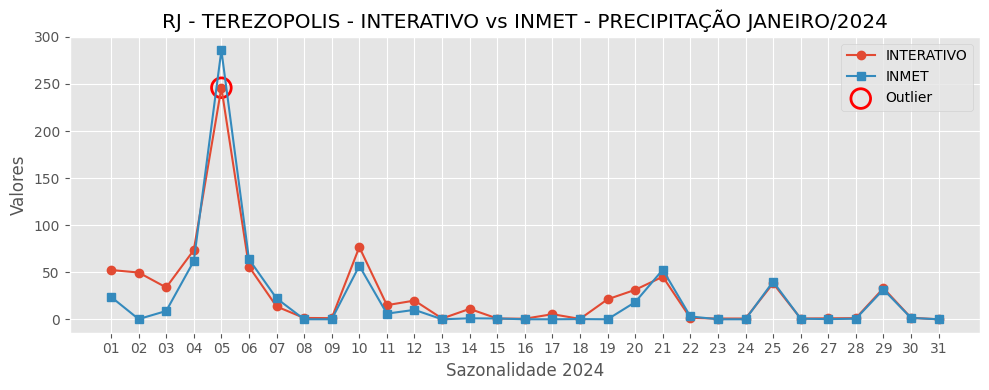

In [45]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# Dados fornecidos manualmente
dados = [f"{i:02}" for i in range(1, 32)]
interativo = [52.34, 49.68, 33.8, 73.49, 246, 56, 13.6, 1.4, 1.2, 76.69, 15, 19.88, 0.8, 11.04, 0.8, 0.6, 5.4, 0.4, 21.23, 31.28, 45.2, 1.4, 0.8, 0.8, 38.2, 0.8, 1, 1.2, 33, 1.6, 0]
inmet = [23.8, 0.2, 8.8, 61.8, 285.8, 63.8, 22.2, 0, 0, 56.8, 6, 10, 0, 1, 0.8, 0, 0, 0.2, 0, 18.2, 52.6, 3, 0, 0, 40, 0.6, 0.2, 0.6, 31.6, 1.4, 0]

# Criar DataFrame com datas
df = pd.DataFrame({
    "Dia": pd.date_range(start="2024-01-01", periods=len(dados), freq='D'),
    "INTERATIVO": interativo,
    "INMET": inmet
})

# Converter datas para string com apenas o dia
df["Dia_str"] = df["Dia"].dt.strftime('%d')

# Identificar índice do outlier em INTERATIVO (valor 246)
outlier_idx = df["INTERATIVO"].idxmax()
outlier_dia = df.loc[outlier_idx, "Dia_str"]
outlier_valor = df.loc[outlier_idx, "INTERATIVO"]



# Plotar gráfico
plt.figure(figsize=(10, 4))
#plt.figure(figsize=(12, 6))
plt.plot(df["Dia_str"], df["INTERATIVO"], label="INTERATIVO", marker='o')
plt.plot(df["Dia_str"], df["INMET"], label="INMET", marker='s')

# Destacar outlier com círculo
plt.scatter(outlier_dia, outlier_valor, s=200, edgecolors='red', facecolors='none', linewidths=2, label="Outlier")

plt.title("RJ - TEREZOPOLIS - INTERATIVO vs INMET - PRECIPITAÇÃO JANEIRO/2024")
plt.xlabel("Sazonalidade 2024")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
